<a href="https://colab.research.google.com/github/baban9/Big-Data-Analytics/blob/master/unSupervized_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/Shareddrives/PySpark')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.gtlib.gatech.edu/pub/apache/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.1-bin-hadoop2.7.tgz

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/Shareddrives/PySpark/spark-3.0.1-bin-hadoop2.7"

import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
sc = SparkConf()
spark=SparkSession.builder.appName("cest-la-vie")\
    .master("local[*]").config(conf=sc).getOrCreate()

In [4]:
df=spark.read.csv('/content/drive/Shareddrives/PySpark/Iris.csv',inferSchema=True,header=True)
# print((df.count(), len(df.columns)))

In [5]:
df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- SepalLengthCm: double (nullable = true)
 |-- SepalWidthCm: double (nullable = true)
 |-- PetalLengthCm: double (nullable = true)
 |-- PetalWidthCm: double (nullable = true)
 |-- Species: string (nullable = true)



In [6]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler
input_cols=['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
vec_assembler = VectorAssembler(inputCols = input_cols,outputCol='features')
final_data = vec_assembler.transform(df)

In [17]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()
errors=[]

for k in range(2,10):
  kmeans = KMeans(featuresCol='features',k=k)
  model = kmeans.fit(final_data)
  predictions = model.transform(final_data)
  silhouette = evaluator.evaluate(predictions)
  # intra_distance = model.computeCost(final_data)
  errors.append(silhouette)


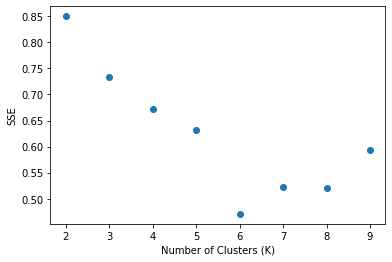

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
cluster_number = range(2,10)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.scatter(cluster_number,errors)
plt.show()

In [23]:
kmeans = KMeans(featuresCol='features',k=6)
model = kmeans.fit(final_data)
model.transform(final_data).groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|   23|
|         3|   32|
|         5|   27|
|         4|   13|
|         2|   16|
|         0|   39|
+----------+-----+



In [24]:
predictions=model.transform(final_data)
predictions.groupBy('species','prediction').count().show()

+---------------+----------+-----+
|        species|prediction|count|
+---------------+----------+-----+
|    Iris-setosa|         1|   23|
|    Iris-setosa|         5|   27|
| Iris-virginica|         3|   32|
|Iris-versicolor|         2|   15|
|Iris-versicolor|         0|   22|
| Iris-virginica|         0|   17|
| Iris-virginica|         2|    1|
|Iris-versicolor|         4|   13|
+---------------+----------+-----+



# Visualization of Clusters

In [25]:
pandas_df = predictions.toPandas()
pandas_df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,features,prediction
0,1,5.1,3.5,1.4,0.2,Iris-setosa,"[5.1, 3.5, 1.4, 0.2]",5
1,2,4.9,3.0,1.4,0.2,Iris-setosa,"[4.9, 3.0, 1.4, 0.2]",1
2,3,4.7,3.2,1.3,0.2,Iris-setosa,"[4.7, 3.2, 1.3, 0.2]",1
3,4,4.6,3.1,1.5,0.2,Iris-setosa,"[4.6, 3.1, 1.5, 0.2]",1
4,5,5.0,3.6,1.4,0.2,Iris-setosa,"[5.0, 3.6, 1.4, 0.2]",5


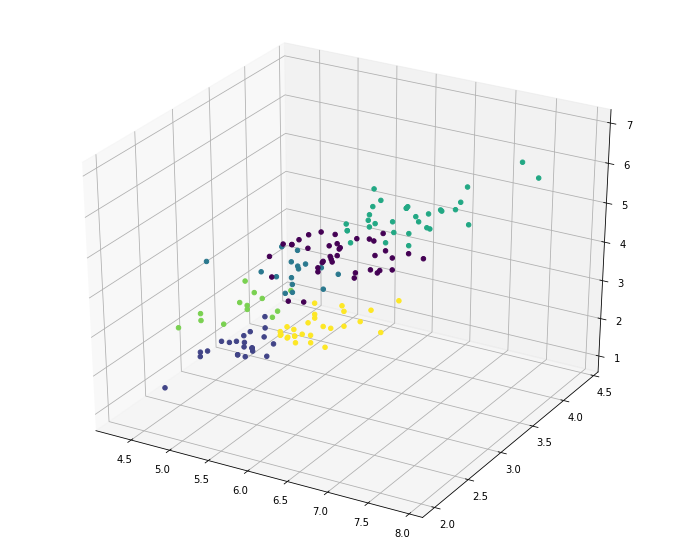

In [26]:
from mpl_toolkits.mplot3d import Axes3D
cluster_vis = plt.figure(figsize=(12,10)).gca(projection='3d')
cluster_vis.scatter(pandas_df.SepalLengthCm, pandas_df.SepalWidthCm, pandas_df.PetalLengthCm, c=pandas_df.prediction,depthshade=False)
plt.show()